# Grad-CAMS Visuals

In [1]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import skimage
from skimage.transform import resize

Using TensorFlow backend.


### Using the VGG16 pretrained network for our grad-cam visualizations.

**The size of the VGG16 input image is 224 X 224 X 3. **

In [2]:
model = VGG16(weights=None)
me = cv2.imread(r'C:/Users/RV/Desktop/DESKTOP DATA/PICS/IMG_20180311_000821107.jpg')
print(me.shape)
me = skimage.transform.resize(me , (224, 224, 3))
me = me.reshape(1,224,224,3)
print(me.shape)
print("-------------------------------------------")
print(me)

(2592, 1944, 3)


C:\Users\RV\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(1, 224, 224, 3)
-------------------------------------------
[[[[ 0.99103641  0.97535014  0.97142857]
   [ 0.98678471  0.97109844  0.96717687]
   [ 0.99215686  0.97647059  0.97254902]
   ..., 
   [ 0.87808123  0.85532213  0.87261905]
   [ 0.88762505  0.86017407  0.88762505]
   [ 0.88627451  0.8627451   0.88235294]]

  [[ 0.98879552  0.97310924  0.96918768]
   [ 0.98796519  0.97227891  0.96835734]
   [ 0.97265906  0.95697279  0.95305122]
   ..., 
   [ 0.90185074  0.87439976  0.89246699]
   [ 0.8960084   0.86855742  0.8960084 ]
   [ 0.87953181  0.85208083  0.87953181]]

  [[ 0.97746098  0.96177471  0.95785314]
   [ 0.98039216  0.96470588  0.96078431]
   [ 0.98823529  0.97254902  0.96862745]
   ..., 
   [ 0.87920168  0.85644258  0.8737395 ]
   [ 0.8792417   0.86571629  0.8892457 ]
   [ 0.89803922  0.87058824  0.89803922]]

  ..., 
  [[ 0.16856743  0.13327331  0.09405762]
   [ 0.16312525  0.13735494  0.09869948]
   [ 0.16228491  0.11848739  0.08711485]
   ..., 
   [ 0.30435174  0.31611645 

In [3]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Notice the weights are loaded till the top layers of 4096, 4096 and 1000 neurons of 3 dense layers respectively.

In [4]:
model.load_weights('Downloads/vgg16_weights_tf_dim_ordering_tf_kernels.h5')

In [5]:
me = preprocess_input(me)

### Now predicting the object and checking the output after the last convolutional layer of block5.

### You can also check for the outputs by other layers of different blocks of VGG16 by providing the necessary name of the layer and changing the value in the for loop in the cell number : 8 of this notebook.

In [6]:
preds = model.predict(me)
class_idx = np.argmax(preds[0])
class_output = model.output[:, class_idx]
last_layer = model.get_layer("block5_conv3")

**Taking the output of the model till the class we have predicted in a 1000.**

In [7]:
print(class_idx)
print(class_output)

644
Tensor("strided_slice:0", shape=(?,), dtype=float32)


### K.gradients returns the gradients of loss w.r.t. variables

**For more info check keras backends.**

In [8]:
grads = K.gradients(class_output, last_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
temp = K.function( [model.input] , [pooled_grads, last_layer.output[0]])
pooled_grads_value , output = temp([me])

for i in range(512):
    output[:, :, i] *= pooled_grads_value[i]

### See the (14X14X512) tensor matches the last layer output in the model summary()

In [9]:
last_layer.output[0]

<tf.Tensor 'strided_slice_2:0' shape=(14, 14, 512) dtype=float32>

In [10]:
print(grads)
print(pooled_grads)
print(pooled_grads_value[0:20])

Tensor("gradients/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(?, 14, 14, 512), dtype=float32)
Tensor("Mean:0", shape=(512,), dtype=float32)
[ -8.38027518e-06  -1.67307098e-05   7.69213148e-06  -8.62935303e-06
  -1.18097832e-05  -5.82518805e-06  -1.68139522e-05  -4.32217075e-06
  -6.31963712e-06  -6.13699058e-06  -3.17169361e-06  -2.99521198e-05
   2.83822345e-07   3.49950242e-05  -1.61979351e-05   1.13157075e-05
   2.05808010e-05  -1.28472966e-05   1.12422440e-05   2.50483504e-06]


**Averaging the weighted feature map and normalizing**

In [11]:
heatmap = np.mean(output, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

### Using some opencv to superimpose the heatmap of the image on the original in order to check the focuss of CNN while classifying the image into classes.

In [12]:
img = cv2.imread(r'C:/Users/RV/Desktop/DESKTOP DATA/PICS/IMG_20180311_000821107.jpg')
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

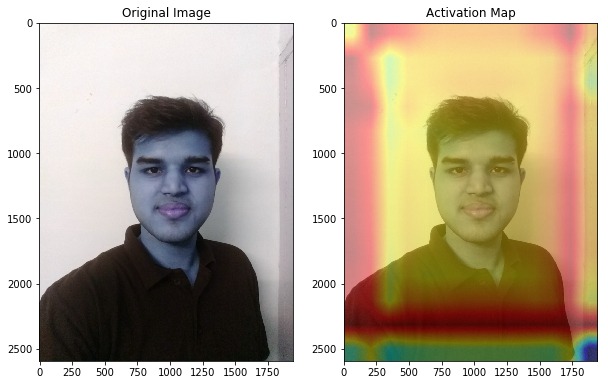

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10,10
plt.subplot(121)
plt.title("Original Image")
plt.imshow(img)
plt.subplot(122)
plt.title("Activation Map")
plt.imshow(superimposed_img)

## Just copying the code from above for a different image....

In [27]:
model = VGG16(weights=None)
lady = cv2.imread('lady.jpg')
print(lady.shape)
lady = skimage.transform.resize(lady , (224, 224, 3))
lady = lady.reshape(1,224,224,3)
print(lady.shape)
print("-------------------------------------------")
print(lady)

(1000, 797, 3)
(1, 224, 224, 3)
-------------------------------------------
[[[[ 0.18721535  0.17937222  0.17937222]
   [ 0.17318803  0.16926646  0.17710959]
   [ 0.14947839  0.14555682  0.15339995]
   ..., 
   [ 0.11238308  0.12961872  0.13354029]
   [ 0.16571629  0.18540588  0.18084531]
   [ 0.16319121  0.16711278  0.15926965]]

  [[ 0.16117525  0.16117525  0.16117525]
   [ 0.15847355  0.16631668  0.17023825]
   [ 0.1295748   0.12565323  0.13349637]
   ..., 
   [ 0.15554628  0.16278074  0.16278074]
   [ 0.10579497  0.12477538  0.11756546]
   [ 0.14074364  0.14858678  0.14858678]]

  [[ 0.14910355  0.14518198  0.15302512]
   [ 0.14178046  0.13785889  0.14570203]
   [ 0.14300689  0.13908532  0.14692846]
   ..., 
   [ 0.11098611  0.13059396  0.12667239]
   [ 0.12178543  0.14139328  0.13747171]
   [ 0.1782327   0.19784054  0.19391897]]

  ..., 
  [[ 0.06688347  0.06349946  0.08919771]
   [ 0.07168446  0.06510182  0.10039594]
   [ 0.05885948  0.06513527  0.11297456]
   ..., 
   [ 0.083105

C:\Users\RV\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [28]:
lady = preprocess_input(lady)
preds = model.predict(lady)
class_idx = np.argmax(preds[0])
class_output = model.output[:, class_idx]
last_layer = model.get_layer("block5_conv3")

In [29]:
print(class_idx)
print(class_output)

498
Tensor("strided_slice_7:0", shape=(?,), dtype=float32)


In [30]:
grads = K.gradients(class_output, last_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
temp = K.function( [model.input] , [pooled_grads, last_layer.output[0]])
pooled_grads_value , output = temp([me])

for i in range(512):
    output[:, :, i] *= pooled_grads_value[i]

In [31]:
print(grads)
print(pooled_grads)
print(pooled_grads_value[0:20])

Tensor("gradients_3/block5_pool_2/MaxPool_grad/MaxPoolGrad:0", shape=(?, 14, 14, 512), dtype=float32)
Tensor("Mean_2:0", shape=(512,), dtype=float32)
[ -3.80276305e-07  -4.07279259e-08   8.66106333e-08  -5.19917656e-08
   9.48783594e-08   2.65623470e-07   2.27713414e-07   3.22502380e-08
  -3.25570511e-07   4.89689675e-08  -4.65620360e-08  -4.22101074e-08
   6.12427243e-07  -1.21876091e-08   1.56223905e-07  -1.13292394e-07
  -1.49880066e-07  -1.32529436e-07   4.27979074e-08   4.95940977e-09]


In [32]:
heatmap = np.mean(output, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

In [33]:
img = cv2.imread('lady.jpg')
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

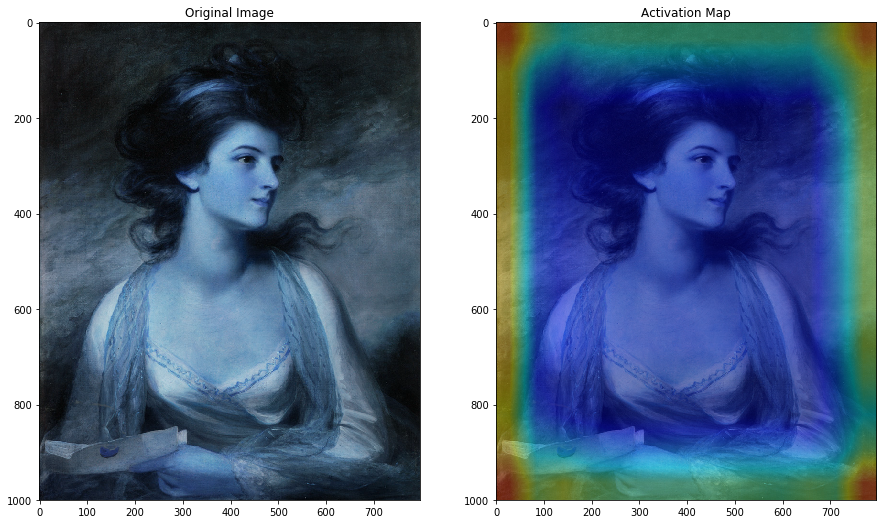

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15
plt.subplot(121)
plt.title("Original Image")
plt.imshow(img)
plt.subplot(122)
plt.title("Activation Map")
plt.imshow(superimposed_img)